In [28]:
# Imports
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
import gc
from sklearn.metrics import confusion_matrix
from collections import Counter

In [3]:
# Loading the preproessad dataset
customer_df = pd.read_csv("/Users/diegolemos/Masters/Theses/code/data/processed/customer_english.csv")

In [4]:
# Displaying the dataframe head
customer_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,thread_id,clean_text,lang
0,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,8.0,and how do you propose we do that,en
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,8.0,I have sent several private messages and no on...,en
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,8.0,is the worst customer service,en
3,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,18.0,You gonna magically change your connectivity f...,en
4,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,@sprintcare Since I signed up with you....Sinc...,15,17.0,18.0,Since I signed up with you....Since day 1,en


### Sentiment Labeling Summary

To prepare the dataset for the model training, we will apply three sentiment labeling approaches:

 1 - VADER: A rule-based, lexicon-driven sentiment analyser. It is fast and interpretable but limited in understanding context and sarcasm.

2 -  DistilBERT: A smaller and faster transformer model fine-tuned for sentiment analysis. It understands context but is more computationally intensive.

3 - RoBERTa: A robust transformer-based model already pre-trained on Twitter data, offering strong performance for sentiment analysis, especially in informal text.

The outputs from each model will be saved and used in a weak supervision approach to train downstream models.


## VADER

In [5]:
# VADER Labelling
sia = SentimentIntensityAnalyzer()

# Applying sentiment score to each message
vader_scores = []
for text in customer_df['clean_text']:
    score = sia.polarity_scores(text)['compound']
    vader_scores.append(score)
    
customer_df['vader_score'] = vader_scores

# Convert compound score to label
def get_vader_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

customer_df['vader_label'] = customer_df['vader_score'].apply(get_vader_label)

In [6]:
# Saving the VADER-labelled dataset
customer_df.to_csv("/Users/diegolemos/Masters/Theses/code/data/processed/vader/customer_vader.csv", index=False)

In [7]:
# Checking VADER labels
customer_df[['clean_text', 'vader_score', 'vader_label']].sample(10)

,clean_text,vader_score,vader_label
344347,yep! i’ll press flashlight and it’ll take a co...,0.2244,positive
975399,I checked and I had to call CC again for the 5...,0.2259,positive
952886,"hello! For Match &amp; More xmas coupon, spend...",-0.3080,negative
1222747,any news on better stocks of Hue Lights? The 3...,0.2640,positive
895603,"It's an old app because it's a first gen iPad,...",0.0000,neutral
1295644,Had a folder that I wasn't synching to a speci...,0.0000,neutral
312334,How do I report a missing item? Like not in th...,0.1759,positive
1241839,An email i got from you is the same generic co...,-0.0752,negative
830682,Day by day services provided by Uber r deterio...,0.4084,positive
940025,Just changed my iCloud password (still logged ...,-0.7890,negative


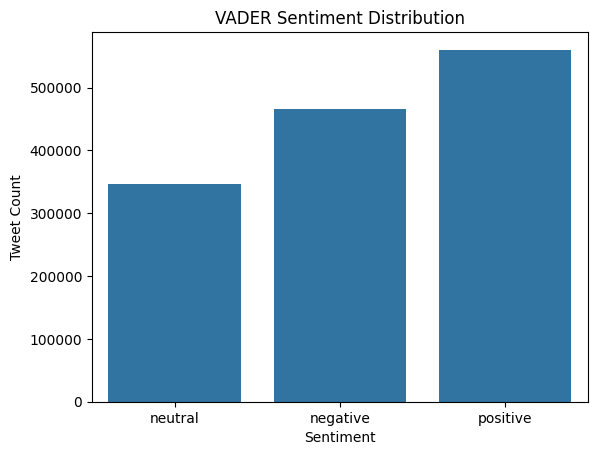

In [15]:
# Plotting Sentiment Distribution
sns.countplot(data=customer_df, x='vader_label')
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()

#### VADER Labelling
To beggin with the sentiment labelling, we have applied the VADER (Valence Aware Dictionary and sEntiment Reasoner), a lexcon and rule-based sentiment analysis tool. It was used on customer messages especifically, those where  'inbound' was equal (==) to 'True'. The VADER logic classifies  as positive if compound score is >= 0.05, negative  if it is <= -0.05 and neutral otherwise.

This labelling step is part of this projects' weak sepervision strategy, where we are goint to assign sentiment label to unlabelled customer messages, these labels will be later used directly for models training, compered with labels from transformer-based models like DistilBERT and RoBERTa and refine with manual review.

### DistilBERT

In [ ]:
# Initializing DistilBERT Labelling
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Making sure all text is string
customer_df['clean_text'] = customer_df['clean_text'].astype(str)

# Setup folder to save outputs
output_folder = "/Users/diegolemos/Masters/Theses/code/data/processed/DistilBERTChunks"
os.makedirs(output_folder, exist_ok=True)

# Load model
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Defining function to process text in batches
def distilbert_sentiment_batch(texts, batch_size=128):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="DistilBERT Sentiment"):
        batch = texts[i:i+batch_size].tolist()
        outputs = classifier(batch)
        results.extend([output['label'].lower() for output in outputs])
    return results

# Split into 4 large chunks
num_chunks = 4
chunk_size = len(customer_df) // num_chunks
chunks = [customer_df.iloc[i:i+chunk_size] for i in range(0, len(customer_df), chunk_size)]

# Apply sentiment and save each chunk
for idx, chunk in enumerate(chunks):
    print(f"\n Processing chunk {idx+1}/{len(chunks)}")
    chunk = chunk.copy()
    chunk['distilbert_label'] = distilbert_sentiment_batch(chunk['clean_text'])
    
    # Save file
    chunk.to_csv(f"{output_folder}/distilbert_chunk_{idx+1}.csv", index=False)


In [19]:
# Marging DistilBERT Labels
chunk_files = sorted(glob.glob(f'/Users/diegolemos/Masters/Theses/code/data/processed/DistilBERTChunks/distilbert_chunk_*.csv'))

# Loading each chunk file into a list
dfs = []
for file in chunk_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenating all chunks into a single Dataframe
distilbert_df = pd.concat(dfs, ignore_index=True)

# Saving dataset with DistilBERT Labels
distilbert_df.to_csv('/Users/diegolemos/Masters/Theses/code/data/processed/customer_with_distilbert.csv')
    

In [22]:
# Checking DistilBERT labelling
distilbert_df[['clean_text', 'distilbert_label']].head(10)

,clean_text,distilbert_label
0,and how do you propose we do that,positive
1,I have sent several private messages and no on...,negative
2,is the worst customer service,negative
3,You gonna magically change your connectivity f...,positive
4,Since I signed up with you....Since day 1,positive
5,y’all lie about your “great” connection. 5 bar...,negative
6,"whenever I contact customer support, they tell...",negative
7,Would you like me to email you a copy of one s...,negative
8,I received this from your corporate office wou...,negative
9,The correct way to do it is via an OCS Account...,positive


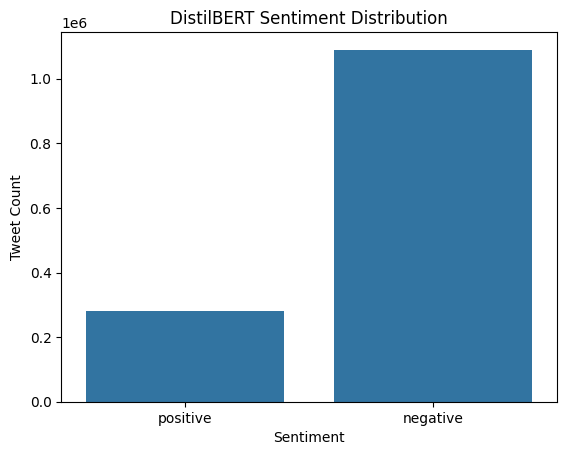

In [20]:
# Plotting DistilBERT Sentiment Distribution
sns.countplot(data=distilbert_df, x='distilbert_label')
plt.title('DistilBERT Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()

#### DistilBERT Lebelling
To complement the sentiment labelling beyonde VADER, we have also applied DistilBERT, a lightweight transformer-based language model fine-tuned for sentiment analysis (distilbert-base-uncased-finetuned-sst-2-english), this model does not have a neutral category, because it was trained using the SST-2 noisy sentence dataset, which only has two sentiment categories available positive and negative.

DistilBERT improves deep learnig and contextual embedding to classify messages as positive and negative with a higher level of semantic undestanding compared to a traditional lexicon-based approches.

We have used DistilBERT with the objective of introduce a more context-aware perspective into the weak supervision strategy, this model has been applied to the same subset of customer message or 'inbound = true' and resulting predictions will be used to compare and potentially combine with the VADER labels to improve overall label quality.

This process is crutial for generating pseudo-lebels that will later be used for training supervised machine learning and deep learning models.

### RoBERTa

In [ ]:
# Loading RoBERTa pipeline
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
df = customer_df.copy()

# Setup folder to save outputs
output_folder = "/Users/diegolemos/Masters/Theses/code/data/processed/RoBERTaChunks"
os.makedirs(output_folder, exist_ok=True)

# Split into 5 large chunks
chunk_size = len(df) // 5
chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# Running sentiment labeling on each chunk
for idx, chunk in enumerate(chunks):
    print(f"\n Processing chunk {idx + 1}/{len(chunks)}")

    texts = chunk['clean_text'].tolist()
    predictions = roberta_classifier(texts, truncation=True, max_length = 128)

    # Add new label column
    chunk['roberta_label'] = [pred['label'].lower() for pred in predictions]
    chunk['roberta_score'] = [pred['score'] for pred in predictions]

    # Save chunk
    filename = os.path.join(output_folder, '/roberta_chunk_{idx + 1}.csv')
    chunk.to_csv(filename, index=False)


In [14]:
# Marging RoBERTa Labels
chunk_files = sorted(glob.glob(f'/Users/diegolemos/Masters/Theses/code/data/processed/RoBERTaChunks/roberta_chunk_*.csv'))

# Loading each chunk file into a list
dfs = []
for file in chunk_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenating all chunks into a single Dataframe
roberta_df = pd.concat(dfs, ignore_index=True)

# Saving dataset with DistilBERT Labels
roberta_df.to_csv('/Users/diegolemos/Masters/Theses/code/data/processed/customer_with_roberta.csv')

In [15]:
# Checking RoBERTa labelling
roberta_df[['clean_text', 'roberta_label']].head(10)

,clean_text,roberta_label
0,and how do you propose we do that,label_1
1,I have sent several private messages and no on...,label_0
2,is the worst customer service,label_0
3,You gonna magically change your connectivity f...,label_1
4,Since I signed up with you....Since day 1,label_1
5,y’all lie about your “great” connection. 5 bar...,label_0
6,"whenever I contact customer support, they tell...",label_0
7,Would you like me to email you a copy of one s...,label_1
8,I received this from your corporate office wou...,label_1
9,The correct way to do it is via an OCS Account...,label_1


In [16]:
#  Mapping RoBERTa numeric labels to text
label_map = {
    "label_0": "negative",
    "label_1": "neutral",
    "label_2": "positive"
}
roberta_df['roberta_label'] = roberta_df['roberta_label'].map(label_map)

In [17]:
# Saving the updated RoBERTa-labeled
roberta_df.to_csv('/Users/diegolemos/Masters/Theses/code/data/processed/customer_with_roberta.csv', index=False)

In [18]:
# Checking RoBERTa labelling after mapping
roberta_df[['clean_text', 'roberta_label']].head(10)

,clean_text,roberta_label
0,and how do you propose we do that,neutral
1,I have sent several private messages and no on...,negative
2,is the worst customer service,negative
3,You gonna magically change your connectivity f...,neutral
4,Since I signed up with you....Since day 1,neutral
5,y’all lie about your “great” connection. 5 bar...,negative
6,"whenever I contact customer support, they tell...",negative
7,Would you like me to email you a copy of one s...,neutral
8,I received this from your corporate office wou...,neutral
9,The correct way to do it is via an OCS Account...,neutral


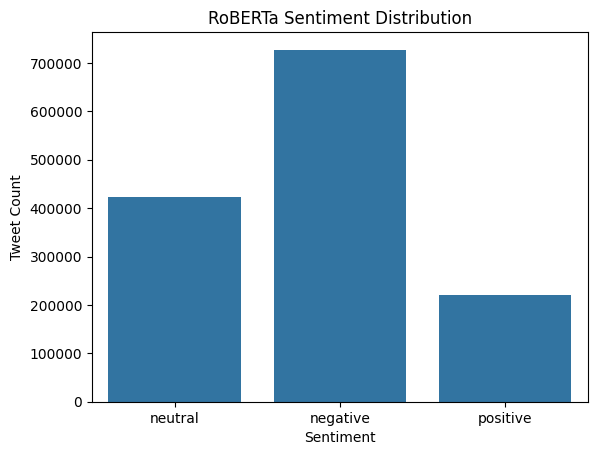

In [18]:
# Plotting RoBERTa Sentiment Distribution
sns.countplot(data=roberta_df, x='roberta_label')
plt.title('RoBERTa Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()

#### RoBERTa Labelling
We have also used RoBERTa, another powerful transformer-based model that has been pre-trained on an extensive corpus of English text and is tailored for subsequent NLP tasks, to improve sentiment labeling even more, in particular, we employed a 'cardiffnlp/twitter-roberta-base-sentiment-based' sentiment classification pipeline.

RoBERTa performs exceptionally well on sentiment analysis tasks, especially when used for casual customer messages or social media. It is particularly well-suited for our dataset because of its pretraining on Twitter data, which improves its ability to capture subtleties, slang, and short-form language.

Label_0, label_1, and label_2 are the sentiment labels assigned by the RoBERTa classifier, these represent negative, neutral, and positive sentiments, respectively. Later, these were converted into labels that people could read.

In order expand our weak supervision approach, we employed RoBERTa as a complementary model in addition to VADER and DistilBERT. The objective was to increase label accuracy by utilizing its contextual and domain-aware knowledge. By comparing predictions from different models, inconsistencies can be found and more trustworthy pseudo-labels can be created for use in training machine learning and deep learning models later on.

### VADER VS DistilBERT VS RoBERTa Label Comparison and Merging

In [15]:
# Files paths
vader_path = '/Users/diegolemos/Masters/Theses/code/data/processed/vader/customer_vader.csv'
distilbert_path = '/Users/diegolemos/Masters/Theses/code/data/processed/customer_with_distilbert.csv'
roberta_path = '/Users/diegolemos/Masters/Theses/code/data/processed/customer_with_roberta.csv'

# Reading objects with the right columns
vader_df = pd.read_csv(vader_path, usecols=['clean_text', 'vader_label'])
distilbert_df = pd.read_csv(distilbert_path, usecols=['clean_text', 'distilbert_label'])
roberta_df = pd.read_csv(roberta_path, usecols=['clean_text', 'roberta_label'])

In [16]:
# Clean and ensuring consistent format
for df in [vader_df, distilbert_df, roberta_df]:
    df['clean_text'] = df['clean_text'].astype(str).str.strip().str.lower()
    df.drop_duplicates(subset='clean_text', inplace=True)

In [17]:
# Merging datasets
merged_df = pd.merge(vader_df, distilbert_df, on='clean_text', how='inner')
merged_df = pd.merge(merged_df, roberta_df, on='clean_text', how='inner')


In [18]:
# Renaming columns
merged_df.rename(columns={
    'vader_label': 'vader_sentiment',
    'distilbert_label': 'distilbert_sentiment',
    'roberta_label': 'roberta_sentiment'
}, inplace=True)

In [19]:
# Saving
merged_df.to_pickle('/Users/diegolemos/Masters/Theses/code/data/processed/labelled_data_all_model.pkl')

In [ ]:
# Printing df head
df = pd.read_pickle('/Users/diegolemos/Masters/Theses/code/data/processed/labelled_data_all_model.pkl')
df.head()

,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment
0,and how do you propose we do that,neutral,positive,neutral
1,i have sent several private messages and no on...,negative,negative,negative
2,is the worst customer service,negative,negative,negative
3,you gonna magically change your connectivity f...,negative,positive,neutral
4,since i signed up with you....since day 1,neutral,positive,neutral


In [22]:
# Printing the informations of the merged dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345727 entries, 0 to 1345726
Data columns (total 4 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   clean_text            1345727 non-null  object
 1   vader_sentiment       1345727 non-null  object
 2   distilbert_sentiment  1345727 non-null  object
 3   roberta_sentiment     1345727 non-null  object
dtypes: object(4)
memory usage: 41.1+ MB


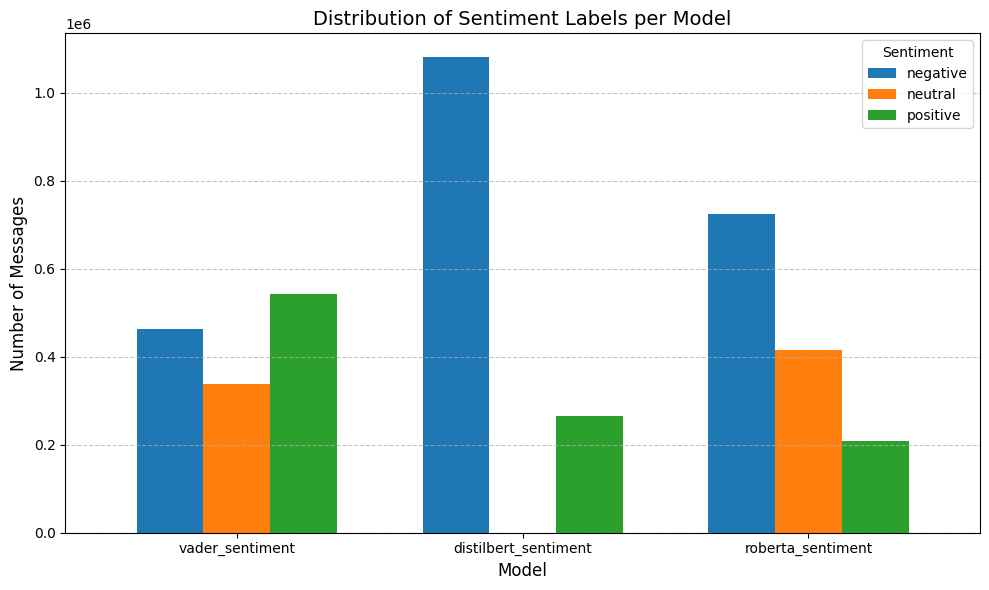

In [23]:
# Getting value counts from each model
label_counts = df[['vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']].apply(pd.Series.value_counts)

# Reorganizing index for a better disply
label_counts = label_counts.loc[['negative', 'neutral', 'positive']]
label_counts = label_counts.T

# Plotting sentiment distribution per model
ax = label_counts.plot(kind='bar', figsize=(10, 6), width=0.7)
plt.title('Distribution of Sentiment Labels per Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [24]:
# Agreement column
df['agreement'] = (
    (df['vader_sentiment'] == df['distilbert_sentiment']) &
    (df['vader_sentiment'] == df['roberta_sentiment'])
)

# Counting of agreement
agreement_counts = df['agreement'].value_counts()
print("Agreement vs Disagreement:\n", agreement_counts)

Agreement vs Disagreement:
 agreement
False    817174
True     528553
Name: count, dtype: int64


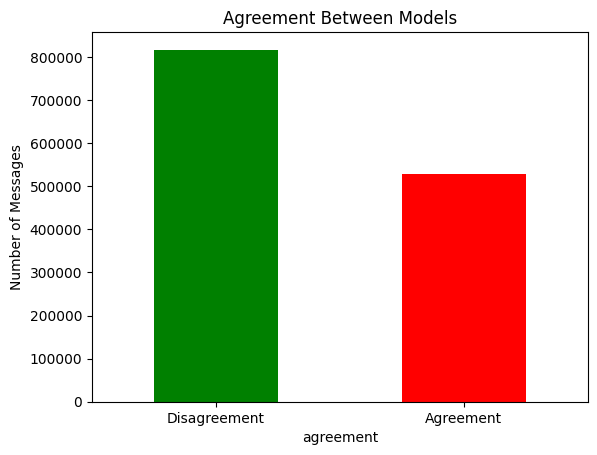

In [25]:
import matplotlib.pyplot as plt

agreement_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Agreement Between Models')
plt.xticks(ticks=[0,1], labels=['Disagreement', 'Agreement'], rotation=0)
plt.ylabel('Number of Messages')
plt.show()


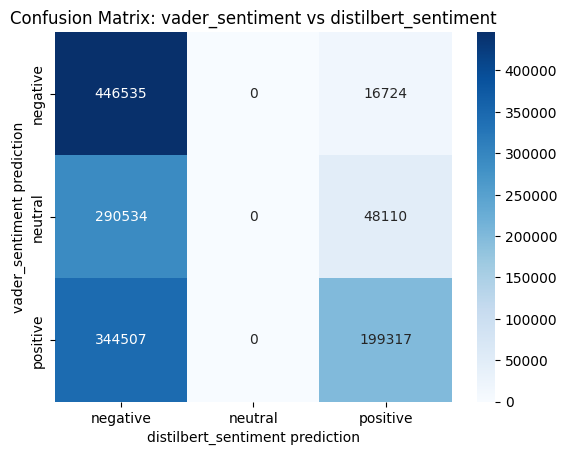

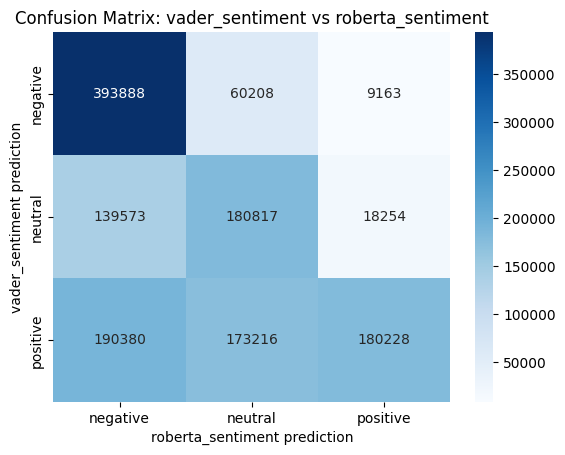

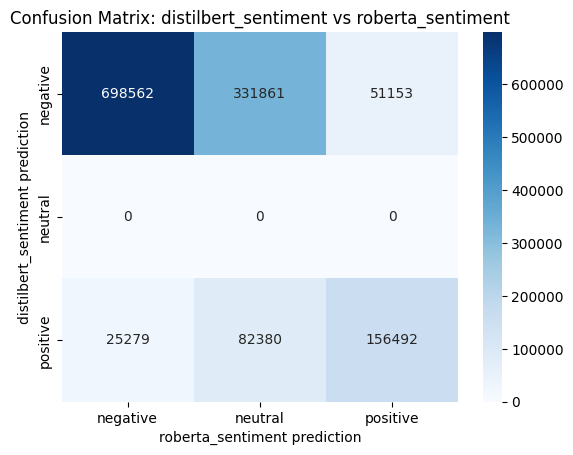

In [ ]:
# Plotting confusion matrices pairwase
def plot_conf_matrix(model1, model2, data=df):
    cm = confusion_matrix(data[model1], data[model2], labels=['negative', 'neutral', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.xlabel(f"{model2} prediction")
    plt.ylabel(f"{model1} prediction")
    plt.title(f"Confusion Matrix: {model1} vs {model2}")
    plt.show()

# Runing pairwise:
plot_conf_matrix('vader_sentiment', 'distilbert_sentiment')
plot_conf_matrix('vader_sentiment', 'roberta_sentiment')
plot_conf_matrix('distilbert_sentiment', 'roberta_sentiment')


#### Comparing between Models and Agreement Analysis

In order to increase the label reliability and overcome the shortcomings of using only one model to predict the sentiment, we compared the performances of three different models such as VADER, DistilBERT and RoBERTa. The single preprocessed dataset was independently modelled with each model individually yielding separate sentiment labels. They were then combined into a single dataframe to be further observed.

It was aimed at checking the consistency, disclosing disagreements, and finally developing a more accurate labelling strategy.

##### Sentiment Distribution

The sentiment output of each model was analysed first to see whether there are any biases or skewed label distributions:
VADER showed a fairly clean spread among the positive, neutral, and the negative feelings.
DistilBERT was biased towards negative predictions, lacking neutral sentiment at all, the reason being that it was either caused by the behaviour of the model or label mapping.
RoBERTa exhibited a significant proportion of negative labels, nevertheless, yielding a sufficient percentage of positive and neutral responses.

These distributions assisted us in realising the differences and provided the basis of subsequent analysis.

##### Agreement Analysis

To measure the frequency of the models making matching sentiments, we set the column of agreements:
True in case all the three models provided the same label.
Untrue in case of any mismatch.

The models too surprisingly did not agree on an upwards of 50 percentages of the messages where they could agree on only ~39 percentages. This proves to the significance of integrating the models as opposed to using one of them.

A basic bar chart was created in order to appear the agreement vs disagreement.

##### Pairwise Confusion Matrix

In order to get a better sense of our disagreement we calculated the confusion matrices between every pair of models:
VADER - DistilBERT
VADER versus RoBERTa
DistilBERT Vs RoBERTa

Such matrices indicated some typical patterns of misalignment, including:
DistilBERT that labeled a large amount of VADER neutral or positive messages as negative.
RoBERTa, being much more similar to VADER yet with some divergences, especially with neutral sentiment.

These learnings will prove critical in the following step we will establish a final label whose will be done on the basis of rule-based or majority voting thinking.

### Final Label

In [51]:
# Applying hybrid mergind stratergy
def get_final_label(row):
    labels = [row['vader_sentiment'], row['distilbert_sentiment'], row['roberta_sentiment']]
    
    # When all three agree
    if labels.count(labels[0]) == 3:
        return labels[0]
    
    #If two agree, one is RoBERTa
    if row['roberta_sentiment'] == row['vader_sentiment'] or row['roberta_sentiment'] == row['distilbert_sentiment']:
        return row['roberta_sentiment']
    
    #If two agree, but not with RoBERTa
    if row['vader_sentiment'] == row['distilbert_sentiment']:
        return row['vader_sentiment']
    
    #If All disagree fallback to majority vote
    return max(set(labels), key=labels.count)

df['final_sentiment'] = df.apply(get_final_label, axis=1)

In [52]:
# Saving labelled dataset with final sentiment to pickle
df.to_pickle('/Users/diegolemos/Masters/Theses/code/data/processed/customer_data_final.pkl')

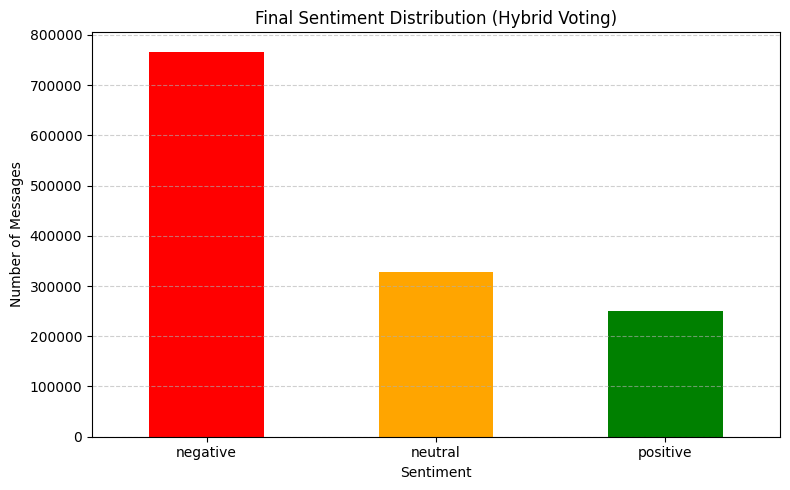

In [53]:
# Plotting the final distribution
df['final_sentiment'].value_counts().loc[['negative', 'neutral', 'positive']].plot(
    kind='bar',
    title='Final Sentiment Distribution (Hybrid Voting)',
    xlabel='Sentiment',
    ylabel='Number of Messages',
    figsize=(8, 5),
    color=['red', 'orange', 'green']
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Final Labels Hybrid Merging Strategy

To establish a stable target variable that our models would be trained on, we combined the results of VADER, DistilBERT and RoBERTa in a hybrid voting approach:

In case of unanimous similarity among the three models, the label is given to it.
In case of two models voting in the affirmative and one of those models be RoBERTa, then we assume that RoBERTa is correct and abide by that term.
When they do not all agree then we fallback to the majority voting.

This strategy guarantees that we can enjoy the benefit of having transformer-based models such as RoBERTa that are robust to word interchange as well as honor consensus in the presence of the same. It is between reliability and coverage, so it is good in weak supervision and training of models.


In [54]:
# Showing 50 random samples per sentiment class for manual review
for label in ['positive', 'neutral', 'negative']:
    print(f"\nExamples for label: {label.upper()}")
    display(
        df[df['final_sentiment'] == label]
        .sample(50, random_state=42)[
            ['clean_text', 'vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment', 'final_sentiment']
        ]
    )


Examples for label: POSITIVE


,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment,final_sentiment
294295,genuinely enjoyed will ferrell keeping me comp...,positive,positive,positive,positive
775456,love a good glitch 🙄,positive,positive,positive,positive
880751,well if the friendly skies are cooperating and...,positive,positive,positive,positive
281877,thanks. we’ve already discussed the only locat...,positive,positive,neutral,positive
591511,totes you are the best!! here’s another gate d...,positive,positive,positive,positive
1211235,how you were able to make the podcast app so s...,negative,positive,positive,positive
282490,you have to love our flight was supposed to le...,positive,negative,positive,positive
919615,no need to apologize...just hoping picks up th...,positive,positive,positive,positive
1000573,if your partner is dragging you around don't w...,positive,positive,positive,positive
715464,so is there any way you can help with this bec...,positive,positive,neutral,positive



Examples for label: NEUTRAL


,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment,final_sentiment
215183,true i know that. but if he quickly logs in on...,positive,negative,neutral,neutral
1323479,son of a beeeech :( .... ... ya'll surely coul...,positive,negative,neutral,neutral
859767,"psa if you have anywhere to be, don't stop at ...",positive,negative,neutral,neutral
811110,can u please explain: my hi def pic is gone du...,positive,negative,neutral,neutral
1306957,dear my app purchased 2 tickets for the same j...,positive,negative,neutral,neutral
1094953,any news on the visa issue?,neutral,negative,neutral,neutral
153110,ever since rocket league released their autumn...,neutral,positive,neutral,neutral
1226693,"...also, i am on ps4 pro. i don’t think the pa...",positive,negative,neutral,neutral
312733,"hi cs team, can you confirm tel # for store in...",positive,negative,neutral,neutral
144379,i am looking for the following game:,neutral,negative,neutral,neutral



Examples for label: NEGATIVE


,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment,final_sentiment
570776,might want to retrain the staff at your head o...,negative,negative,negative,negative
46481,"already did, and was met with poor customer se...",negative,negative,negative,negative
1053076,"received email from cancelling an order for ""s...",positive,negative,negative,negative
149267,i canceled it right away when i realized it wa...,negative,negative,negative,negative
1260502,"when the order you placed last sat, with deliv...",neutral,negative,negative,negative
244727,lost argos card. is there anyway to buy someth...,negative,negative,neutral,negative
1191072,i rebuilt the database and it did not correct ...,neutral,negative,negative,negative
259992,"i've tried everything - different devices, net...",neutral,negative,negative,negative
779704,when someone pays to overnight you something v...,neutral,negative,negative,negative
210066,when will we get new update on high sierra??? ...,negative,negative,negative,negative


#### Final Label and Manual Review
In order to check the quality of automatically generated sentiment labels we manually sampled 50 labels each on different three sentiments classes (positive, neutral, negative). The idea of the process acted as a qualitative sanity check to determine whether the artifact of the hybrid strategy corresponded to the judgment of humans in cases of ambiguity.

Key Findings:
Positive Sentiment: Various entries that had the labels of positive seemed neutral stronger in those cases where only VADER was positive in labeling. In such instances RoBERTa tended to dissent, and the text was classified as neutral, which is closer to the human understanding.

Neutral Sentiment: Overall there was consistency with this sentiments emotion in the various models, although it may be converted to a negative form when there is a mild complaint where VADER is concerned.

Negative Sentiment: High degree of concurrence between models in very critical or emotionally charged messages, which implies high degrees of confidence of the labeling.

This review affirmed the usefulness of the contextual understanding which RoBERTa brought to the control of the hybrid rules in cases where VADER and DistilBERT had noisier results.

Perfect label quality is not assured since this is a weakly supervised arrangement. The hybrid voting mechanism, however, offers practical tradeoffs of trust in state-of-the-art models and rule-based consensus.